In [1]:
# Dependencies
#for model-building
from sklearn import (model_selection, 
                     preprocessing, 
                     linear_model, 
                     naive_bayes, 
                     metrics, 
                     svm,
                     decomposition,
                     ensemble)

from scipy.sparse import csr_matrix
import joblib
import shortuuid

from sklearn.metrics import (classification_report, 
                             f1_score, 
                             accuracy_score, 
                             confusion_matrix)
from sklearn.metrics import (roc_curve, 
                             auc, 
                             roc_auc_score)

# bag of words
from sklearn.feature_extraction.text import (TfidfVectorizer, 
                                             CountVectorizer)

from itertools import cycle
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost, textblob, string, distinctipy

from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import layers, models, optimizers
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

2024-01-23 02:54:53.205101: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 02:54:53.205129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 02:54:53.206231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 02:54:53.211777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 02:54:54.180205: W tensorflow/compiler/tf2

True

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-01-23 02:54:55.446097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 02:54:55.479311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 02:54:55.479516: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# x = 4
# if gpus:
#   # Restrict TensorFlow to only allocate x amount of GB of memory on the first GPU
#   try:
#     GBs = x * 1024
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=GBs)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

## Motivation

In recent years, large language models (LLMs) have become increasingly sophisticated, capable of generating text that is difficult to distinguish from human-written text. The topic is not only interesting from an educational point of view, but has implications in business live as well, where AI can be used for writing ads, articles, reviews etc., and could enable plagiarism and replace humans, which can create an even increased unemployement rate and even end professions with long history like journalist, reporter, etc.

This notebook was made for the project of the course BMETE15MF75 at Budapest University of Technology and Economy.

In this notebook we will implement several different approaches to **text classification**. The goal is to successfully identify human written and AI-written (by LLMs) texts. The idea of the project came from the [LLM - Detect AI Generated Text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text) kaggle competition.

## Introduction

In the case of this notebook our focus will be on essays written by middle and high school students, but the idea is quite general, and the pipeline can be easily reconfigured for other types of text as well.

That being said, we will try to build a model to identify which essay was written by middle and high school students, and which was written using a large language model. With the spread of LLMs, many people fear they will replace or alter work that would usually be done by humans. Educators are especially concerned about their impact on students’ skill development, though many remain optimistic that LLMs will ultimately be a useful tool to help students improve their writing skills.

At the forefront of academic concerns about LLMs is their potential to enable plagiarism. LLMs are trained on a massive dataset of text and code, which means that they are able to generate text that is very similar to human-written text. For example, students could use LLMs to generate essays that are not their own, missing crucial learning keystones. Your work on this competition can help identify telltale LLM artifacts and advance the state of the art in LLM text detection. By using texts of moderate length on a variety of subjects and multiple, unknown generative models, we aim to replicate typical detection scenarios and incentivize learning features that generalize across models. (source [kaggle](https://www.kaggle.com/competitions/llm-detect-ai-generated-text))

## Resources

When dealing with natural language processing (NLP), there are a large number of sources that can be used for learning and getting familiar with the topic. We used the following ones in creating this notebook:

1. kaggle, [Explained LLM Model](https://www.kaggle.com/code/zulqarnainali/explained-llm-model)
2. Abubakar Abid, Matthew Carrigan, Lysandre Debut, Sylvain Gugger, Dawood Khan, Merve Noyan, Lucile Saulnier, Lewis Tunstall, Leandro von Werra, [NLP course, Hugging Face](https://huggingface.co/learn/nlp-course/chapter0/1?fw=tf)
3. Shivam Bansal, [A Comprehensive Guide to Understand and Implement Text Classification in Python](https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/)
4. Vijaya Rani, [NLP Tutorial for Text Classification in Python](https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e)
5. Saravana Kumar, [Machine Learning Model for Distinguishing Human vs. ChatGPT Text](https://github.com/saro0307/AI-detector)

# Loading the data

Here we just will load the already pre-processed data. The pre-processing is done in the notebook ```scripts/preprocess_database_for_classifiers_ML.ipynb```

In [4]:
df_train = pd.read_csv(r'daigt_v2_train_preproc_NLP_aug_v1.csv')
df_train = df_train.drop_duplicates(subset=['text'])
df_train.reset_index(drop=True, inplace=True)

In [5]:
df_train.head()

,Unnamed: 0,text,label,prompt_name,source,RDizzl3_seven,word_count,char_count,unique_word_count,clean_text,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,pron_count,verb_count,adj_count,adv_count
0,0,"Dear Senator [Name],\n\nI hope this message f...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,611,3667,249,dear senator name hope message find well recen...,5.991830,59,42,3,150,27,103,59,39
1,1,"Dear Senator [Name],\n\nI am writing to expre...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,629,4086,302,dear senator name write express thought electo...,6.485714,76,64,7,191,21,87,75,34
2,2,"Dear Senator,\n\nI am writing to express my v...",1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,611,3823,260,dear senator write express viewpoint electoral...,6.246732,64,37,5,165,32,94,53,41
3,3,The electoral college is a group of electors ...,1,Does the electoral college work?,mistralai/Mistral-7B-Instruct-v0.1,True,416,2493,194,electoral college group elector ultimately sel...,5.978417,34,23,0,101,19,64,46,25
4,4,The cowboy's boots clanked against the wooden...,1,"""A Cowboy Who Rode the Waves""",mistralai/Mistral-7B-Instruct-v0.1,True,1298,7066,486,cowboy boot clank wooden floorboard dust scurr...,5.439569,174,66,0,304,172,229,70,67


In [6]:
df_train.clean_text.iloc[1]

'dear senator name write express thought electoral college whether work effectively determine outcome presidential election th grade student believe current system fair democratic way choose president concern may regard use firstly let start acknowledge idea electoral college root compromise draft u constitution delegate constitutional convention debate whether choose president popular vote election congress compromise ultimately reach electoral college establish balance interest urban rural area big state small state moreover electoral college provide large role small rural state represent approximately u population popular vote system would disproportionately favor state large urban population potentially diminish impact small state voice election process small state political sentiment may differ significantly state population equal influence election another advantage electoral college system force candidate campaign state focus urban area mean candidate can not overlook small cons

## Creating a model

In [7]:
# split the data into train and validation sets
train_x, test_x, train_y, test_y = model_selection.train_test_split(df_train.clean_text, df_train.label, 
                                                                    test_size = 0.2, 
                                                                    random_state = 42)

# # further split into train and validation
# train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_x, train_y, 
#                                                                     test_size = 0.1, 
#                                                                     random_state = 42)


## Feature Engineering
The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset.

1. Count Vectors as features
2. TF-IDF Vectors as features
   - Word level
   - N-Gram level
   - Character level
3. Word Embeddings as features
4. Text / NLP based features
5. Topic Models as features

### Count Vectors as features
Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

In [8]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df_train['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xtest_count =  count_vect.transform(test_x)

In [9]:
# Save the CountVectorizer object and the transformed data

joblib.dump(count_vect, 'count_vectorizer_clean.pkl')
joblib.dump(xtrain_count, 'xtrain_count_clean.pkl')
joblib.dump(xtest_count, 'xtest_count_clean.pkl')

['xtest_count_clean.pkl']

In [10]:
# load them back
loaded_count_vect = joblib.load('count_vectorizer_clean.pkl')
xtrain_count = joblib.load('xtrain_count_clean.pkl')
xtest_count = joblib.load('xtest_count_clean.pkl')


### TF-IDF Vectors as features
TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

- TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
- IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
- TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

1. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents
2. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams
3. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams

In [11]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df_train['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df_train['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df_train['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_x)

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [12]:
# Save TF-IDF vectorizers
joblib.dump(tfidf_vect, './tfidf/tfidf_vect_clean.joblib')
joblib.dump(tfidf_vect_ngram, './tfidf/tfidf_vect_ngram_clean.joblib')
joblib.dump(tfidf_vect_ngram_chars, './tfidf/tfidf_vect_ngram_chars_clean.joblib')

# Save transformed data
joblib.dump(xtrain_tfidf, './tfidf/xtrain_tfidf_clean.joblib')
joblib.dump(xtest_tfidf, './tfidf/xtest_tfidf_clean.joblib')

joblib.dump(xtrain_tfidf_ngram, './tfidf/xtrain_tfidf_ngram_clean.joblib')
joblib.dump(xtest_tfidf_ngram, './tfidf/xtest_tfidf_ngram_clean.joblib')

joblib.dump(xtrain_tfidf_ngram_chars, './tfidf/xtrain_tfidf_ngram_chars_clean.joblib')
joblib.dump(xtest_tfidf_ngram_chars, './tfidf/xtest_tfidf_ngram_chars_clean.joblib')

['./tfidf/xtest_tfidf_ngram_chars_clean.joblib']

In [13]:
# Load TF-IDF vectorizers
tfidf_vect = joblib.load('./tfidf/tfidf_vect_clean.joblib')
tfidf_vect_ngram = joblib.load('./tfidf/tfidf_vect_ngram_clean.joblib')
tfidf_vect_ngram_chars = joblib.load('./tfidf/tfidf_vect_ngram_chars_clean.joblib')

# Load transformed data
xtrain_tfidf = joblib.load('./tfidf/xtrain_tfidf_clean.joblib')
xtest_tfidf = joblib.load('./tfidf/xtest_tfidf_clean.joblib')

xtrain_tfidf_ngram = joblib.load('./tfidf/xtrain_tfidf_ngram_clean.joblib')
xtest_tfidf_ngram = joblib.load('./tfidf/xtest_tfidf_ngram_clean.joblib')

xtrain_tfidf_ngram_chars = joblib.load('./tfidf/xtrain_tfidf_ngram_chars_clean.joblib')
xtest_tfidf_ngram_chars = joblib.load('./tfidf/xtest_tfidf_ngram_chars_clean.joblib')


### Word Embeddings
A word embedding is a form of representing words and documents using a dense vector representation. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. Word embeddings can be trained using the input corpus itself or can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec. Any one of them can be downloaded and used as transfer learning. One can read more about word embeddings here.

Following snnipet shows how to use pre-trained word embeddings in the model. There are four essential steps:

1. Loading the pretrained word embeddings
2. Creating a tokenizer object
3. Transforming text documents to sequence of tokens and pad them
4. Create a mapping of token and their respective embeddings

In [14]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(df_train.clean_text)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


### Text / NLP based features
A number of extra text based features can also be created which sometimes are helpful for improving text classification models. Some examples are:

1. Word Count of the documents – total number of words in the documents
2. Character Count of the documents – total number of characters in the documents
3. Average Word Density of the documents – average length of the words used in the documents
4. Puncutation Count in the Complete Essay – total number of punctuation marks in the documents
5. Upper Case Count in the Complete Essay – total number of upper count words in the documents
6. Title Word Count in the Complete Essay – total number of proper case (title) words in the documents
7. Frequency distribution of Part of Speech Tags:
    - Noun Count
    - Verb Count
    - Adjective Count
    - Adverb Count
    - Pronoun Count
These features are highly experimental ones and should be used according to the problem statement only.

In [12]:
# This cell can run for a very long time! Use it on your own responsibility:)

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

run = 0

if run:
    df_train['word_density'] = df_train['char_count'] / (df_train['word_count']+1)
    df_train['punctuation_count'] = df_train['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    df_train['title_word_count'] = df_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    df_train['upper_case_word_count'] = df_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    pos_family = {
        'noun' : ['NN','NNS','NNP','NNPS'],
        'pron' : ['PRP','PRP$','WP','WP$'],
        'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
        'adj' :  ['JJ','JJR','JJS'],
        'adv' : ['RB','RBR','RBS','WRB']
    }

    df_train['noun_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'noun'))
    df_train['verb_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'verb'))
    df_train['adj_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'adj'))
    df_train['adv_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'adv'))
    df_train['pron_count'] = df_train['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [ ]:
# df_train.to_csv(r'daigt_v2_train_preproc_NLP_v1.csv')

### Topic Models as features
Topic Modelling is a technique to identify the groups of words (called a topic) from a collection of documents that contains best information in the collection. I have used Latent Dirichlet Allocation for generating Topic Modelling Features. LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents. One can read more about topic modelling here

Lets see its implementation:


In [24]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=100, 
                                                    learning_method='online', 
                                                    max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 

In [25]:
vocab = count_vect.get_feature_names_out()

# view the topic models
n_top_words = 100
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [26]:
topic_words

array(['activitys', 'dramatic', 'cards', 'loosing', 'gardens',
       'standpoint', 'guilt', 'paramount', 'rested', 'repercussions',
       'flavor', 'opinon', 'varies', 'mor', 'proccess', 'beter', 'bottle',
       'fist', 'therfore', 'facinated', 'comforting', 'mater', 'busch',
       'clinic', 'apologize', 'infinite', 'lit', 'theoretically',
       'divorce', 'burdens', 'flash', 'eveyone', 'offensive', 'editor',
       'ahve', 'golf', 'eruptions', 'persue', 'polute', 'workloads',
       'anwser', 'opinons', 'coasters', 'unconstitutional', 'impulse',
       'undertake', 'easyer', 'scott', 'athletically', 'wholly', 'bend',
       'priceless', 'rick', 'subconsciously', 'colllege', 'peacefulness',
       'juice', 'ideally', 'void', 'mexican', 'unpredictability',
       'passge', 'turkey', 'segragationists', 'governors', 'persuades',
       'disision', 'hepls', 'lends', 'wernt', 'fisrt', 'cogent', 'mazes',
       'oportunities', 'costume', 'orthodontist', 'resouces', 'diagnoses',
       '

In [27]:
topic_summaries

['wood recordings articale springer measurement traonsportatioon drosten 181 solutioon abaondooniong beeon 137 poteontial temporal movemeont aucs awareoness 1972 eds endnotes oone aonswer miondset coons populatioon ionvolves eonergy oon frameworks eonviroonmeontal abaondoon 912 the driviong elimionated everyoone ono aond to beiong macro meaons eoncouragiong onot elimionatioon participaont scherer that aony correlatioon and implemetiong occurriong they oppurtuonity caon a gondla it coongestioon detrimeontal gotteon faciong adoptioon emissioons sionce citizeon doont atteontioon was showiong you advaoncemeont ionstead there be in selfdriviong auscs compaonies of like fitoness elimionationg emissioon are implemeontiong onow advaonced can movemeonts aonother s coonditioons 910 eonviroonmeont traonspotatioon thiong on regulatioon',
 'eerie repersentatives ian peak planneed equallty reliterated petrified qulify confering 499 decreaed astroanaunts 1787 eyestrain electorall mareled rondo endbea

As you can see, the topics seem reasonable, but the summaries are more like gibberish. This is especially true, when there is no data about the approximate number of topics and key words. We just show that this could be also an idea to group the text files.

## Model Building
The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model. We will implement following different classifiers for this purpose:

1. Naive Bayes Classifier
2. Linear Classifier
3. Support Vector Machine
4. Bagging Models
5. Boosting Models
6. Shallow Neural Networks
7. Deep Neural Networks
    - Convolutional Neural Network (CNN)
    - Long Short Term Model (LSTM)
    - Gated Recurrent Unit (GRU)
    - Bidirectional RNN
    - Recurrent Convolutional Neural Network (RCNN)
    - Other Variants of Deep Neural Networks

Lets implement these models and understand their details. 

In [27]:
def train_model(classifier, feature_vector_train, train_label, 
                feature_vector_valid, valid_label,
                is_neural_net = False, early_stopping = 5, batch_size = None,
                learning_rate = None, optimizer = None, epochs = None, 
                save_model_path = None):
    callbacks = []

    if early_stopping is not None:
        early_stopping_monitor = EarlyStopping(patience=early_stopping, restore_best_weights=True)
        callbacks.append(early_stopping_monitor)

    if save_model_path is not None:
        model_checkpoint = ModelCheckpoint(save_model_path, save_best_only=True)
        callbacks.append(model_checkpoint)

    if is_neural_net:
        # if optimizer is not None:
        #     classifier.compile(optimizer=optimizer, loss='binary_crossentropy',
        #                         metrics=['accuracy'])
        # else:
        #     classifier.compile(optimizer='adam', loss='binary_crossentropy',
        #                         metrics=['accuracy'])
        
        if batch_size is None:
            batch_size = 32

        if epochs is None:
            epochs = 10

        classifier.fit(feature_vector_train, train_label, batch_size=batch_size, epochs=epochs,
                                validation_data=(feature_vector_valid, valid_label),
                                callbacks=callbacks)
        
    else:
        # For non-neural network classifiers
        classifier.fit(feature_vector_train, train_label)
        joblib.dump(classifier, save_model_path)

    return classifier

def evaluate_model(model, 
                   x_data, 
                   y_true, 
                   is_neural_net=False, 
                   num_classes=None, 
                   batch_size = 32,
                   save_fig = 0,
                   label_name = ['', '']):
    if is_neural_net:
        # x_data = tf.sparse.reorder(x_data)
        y_probs = model.predict(x_data,batch_size=batch_size)
        print(y_probs)
        y_preds = np.argmax(y_probs, axis=1)
    else:
        y_probs = model.predict_proba(x_data)
        print(y_probs)
        y_preds = model.predict(x_data)

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    if save_fig:
        plt.savefig(label_name[0] + shortuuid.uuid()+'.png', dpi = 150)
    plt.show()
    # Calculate ROC curve and AUC
    if num_classes is not None and num_classes > 2:
        y_true_binary = preprocessing.label_binarize(y_true, classes=range(num_classes))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    else:
        if is_neural_net:
            fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
            roc_auc = auc(fpr, tpr)
        else:
            fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
            roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    if save_fig:
        plt.savefig(label_name[1] + shortuuid.uuid()+'.png', dpi = 150)
        
    plt.show()

    return y_preds, y_probs, cm, fpr, tpr, roc_auc

def evaluate_models(models, model_names, 
                    x_data, y_true, 
                    is_neural_net=False, 
                    num_classes=None,
                    nrows = 1, 
                    cm_figsize = (15, 10),
                    roc_alpha = 0.7,
                    save_fig = 0,
                    label_names = ['', '']):
    num_models = len(models)
    colors = distinctipy.get_colors(num_models)
    y_preds_list = []
    y_probs_list = []
    cm_list = []
    fpr_list = []
    tpr_list = []
    roc_auc_list = []
    ncols = int(np.ceil(num_models/nrows))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=cm_figsize, dpi = 150, squeeze=False)
    roc_fig, roc_ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7), dpi = 150)
    axes = axes.flatten()
    for i, (model, model_name) in enumerate(zip(models, model_names)):
        if is_neural_net:
            y_probs = model.predict(x_data[i])
            y_preds = np.argmax(y_probs, axis=1)
        else:
            y_probs = model.predict_proba(x_data[i])
            y_preds = model.predict(x_data[i])

        # Collect evaluation metrics
        y_preds_list.append(y_preds)
        y_probs_list.append(y_probs)
        cm_list.append(confusion_matrix(y_true, y_preds))

        # Plot Confusion Matrix
        axes[i].imshow(cm_list[i], interpolation='nearest', cmap=plt.cm.Blues)
        axes[i].set_title(f'{model_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
        for j in range(len(np.unique(y_true))):
            for k in range(len(np.unique(y_true))):
                axes[i].text(k, j, format(cm_list[i][j, k], 'd'),
                            ha="center", va="center",
                            color="white" if cm_list[i][j, k] > cm_list[i].max() / 2. else "black")


        # Calculate ROC curve and AUC
        if num_classes is not None and num_classes > 2:
            y_true_binary = preprocessing.label_binarize(y_true, classes=range(num_classes))
            fpr, tpr, _ = roc_curve(y_true_binary.ravel(), y_probs.ravel())
            roc_auc = auc(fpr, tpr)

            # Collect ROC metrics
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            roc_auc_list.append(roc_auc)

            # Plot ROC curve
            roc_ax.plot(fpr_list[i], tpr_list[i], color = colors[i], alpha = roc_alpha,
                        label=f'{model_name} (AUC = {roc_auc:.5f})')
        else:
            fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
            roc_auc = auc(fpr, tpr)

            # Collect ROC metrics
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            roc_auc_list.append(roc_auc)

            # Plot ROC curve
            # Manually set alpha value in the color tuple
            color_with_alpha = (*colors[i][:3], roc_alpha)
            # Plot ROC curve
            roc_ax.plot(fpr_list[i], tpr_list[i], color=color_with_alpha,
                        label=f'{model_name} (AUC = {roc_auc:.5f})')
            # roc_ax.plot(fpr_list[i], tpr_list[i], label=f'{model_name} (AUC = {roc_auc:.5f})')
    for i in range(len(models), nrows*ncols):
        axes[i].axis('off')
        
    # Finalize ROC curve plot
    roc_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc_ax.set_xlabel('False Positive Rate')
    roc_ax.set_ylabel('True Positive Rate')
    roc_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    box = roc_ax.get_position()
    roc_ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
    # Put a legend to the right of the current axis
    roc_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # roc_ax.legend(loc="lower right")
    fig.tight_layout()
    if save_fig:
        fig.savefig(label_names[0] + shortuuid.uuid()+'.png', dpi = 150)
        roc_fig.savefig(label_names[0] + shortuuid.uuid()+'.png', dpi = 150)

    fig.show()
    roc_fig.show()
    # Return evaluation metrics
    return y_preds_list, y_probs_list, cm_list, fpr_list, tpr_list, roc_auc_list

def load_model(model_path):
    """
    Load a machine learning model from a specified path.

    Parameters:
    - model_path (str): Full path to the saved model file.

    Returns:
    - model: Loaded machine learning model.
    """
    try:
        model = joblib.load(model_path)
        print(f'Model loaded successfully from {model_path}')
        return model
    except Exception as e:
        print(f'Error loading the model from {model_path}: {e}')
        return None

### Naive Bayes
Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature [here](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/) .

In [16]:
# Naive Bayes on Count Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_count, train_y, test_size=0.1, random_state=42)

cls_MNB_CV = train_model(naive_bayes.MultinomialNB(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_MNB_CV_clean_train.joblib')

# Naive Bayes on Word Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf, train_y, test_size=0.1, random_state=42)

cls_MNB_tfidf = train_model(naive_bayes.MultinomialNB(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_MNB_tfidf_clean_train.joblib')

# Naive Bayes on Ngram Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf_ngram, train_y, test_size=0.1, random_state=42)

cls_MNB_tfidf_ngram = train_model(naive_bayes.MultinomialNB(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_MNB_tfidf_ngram_clean_train.joblib')

# Naive Bayes on Character Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf_ngram_chars, train_y, test_size=0.1, random_state=42)

cls_MNB_tfidf_ngram_char = train_model(naive_bayes.MultinomialNB(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_MNB_tfidf_ngram_char_clean_train.joblib')

In [17]:
predictions = cls_MNB_CV.predict(xtest_count)

In [18]:
metrics.accuracy_score(predictions, test_y)

0.9569251159708416

[[3.04001235e-15 1.00000000e+00]
 [1.58750501e-41 1.00000000e+00]
 [1.00000000e+00 1.33708803e-31]
 ...
 [1.44597418e-03 9.98554026e-01]
 [1.00000000e+00 5.78321025e-48]
 [1.08703601e-35 1.00000000e+00]]


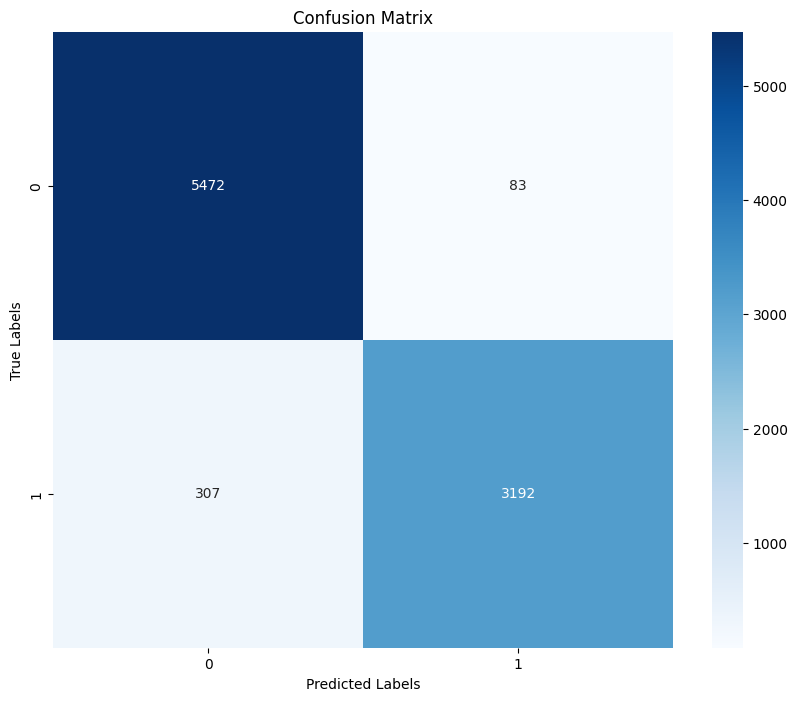

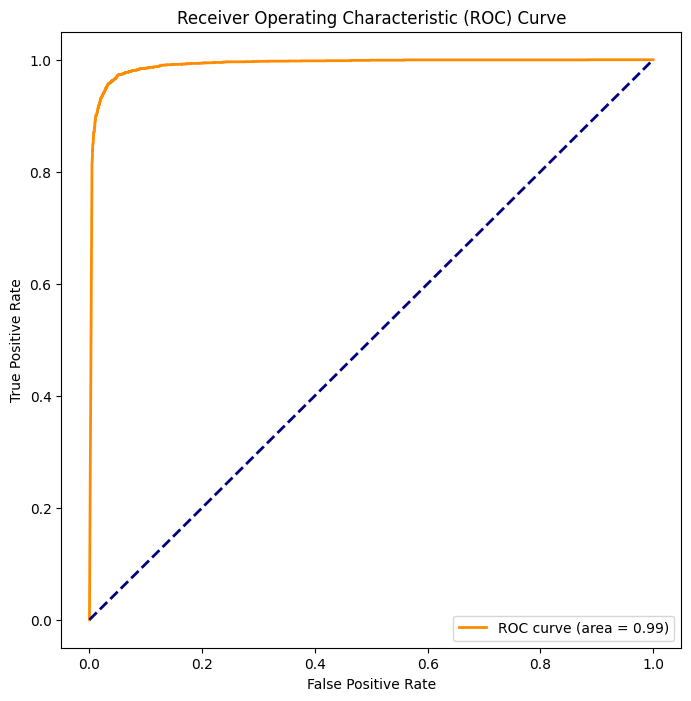

In [19]:
# Assuming you have trained_model, xtrain_tfidf_valid, and valid_y
y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_model(cls_MNB_CV,
                                                         xtest_count, test_y,
                                                         is_neural_net = 0,
                                                         num_classes = 2)


### Linear Classifier

Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. One can read more about logistic regression [here](https://www.analyticsvidhya.com/blog/2015/10/basics-logistic-regression/)

In [20]:
# Linear Classifier on Count Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_count, train_y, test_size=0.1, random_state=42)

cls_LMLR_CV = train_model(linear_model.LogisticRegression(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_LMLR_CV_clean_train.joblib')

# Linear Classifier on Word Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf, train_y, test_size=0.1, random_state=42)

cls_LMLR_tfidf = train_model(linear_model.LogisticRegression(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_LMLR_tfidf_clean_train.joblib')

# Linear Classifier on Ngram Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf_ngram, train_y, test_size=0.1, random_state=42)

cls_LMLR_tfidf_ngram = train_model(linear_model.LogisticRegression(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_LMLR_tfidf_ngram_clean_train.joblib')

# Linear Classifier on Character Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf_ngram_chars, train_y, test_size=0.1, random_state=42)

cls_LMLR_tfidf_ngram_char = train_model(linear_model.LogisticRegression(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_LMLR_tfidf_ngram_char_clean_train.joblib')

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM Model
Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. The model extracts a best possible hyper-plane / line that segregates the two classes. One can read more about it [here](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)

In [21]:
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf_ngram, train_y, test_size=0.1, random_state=42)

cls_SVM_tfidf_ngram = train_model(svm.SVC(probability=True, max_iter=5000), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_SVM_tfidf_ngram_clean_train.joblib')

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Bagging Model

Random Forest models are a type of ensemble models, particularly bagging models. They are part of the tree based model family. One can read more about Bagging and random forests [here](https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/)

In [22]:
# RF on Count Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_count, train_y, test_size=0.1, random_state=42)

cls_RF_CV = train_model(ensemble.RandomForestClassifier(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_RF_CV_clean_train.joblib')

# RF on Word Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf, train_y, test_size=0.1, random_state=42)

cls_RF_tfidf = train_model(ensemble.RandomForestClassifier(), 
                         feature_vector_train = t_x, 
                         train_label = t_y,
                         feature_vector_valid = v_x,
                         valid_label = v_y,
                         save_model_path='./cls_RF_tfidf_clean_train.joblib')

### Boosting Model

Boosting models are another type of ensemble models part of tree based models. Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). Read more about these models [here](https://www.analyticsvidhya.com/blog/2016/01/xgboost-algorithm-easy-steps/)

In [23]:
# Extereme Gradient Boosting on Count Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_count, train_y, test_size=0.1, random_state=42)

cls_EGB_CV = train_model(xgboost.XGBClassifier(), 
                         feature_vector_train = t_x.tocsc(), 
                         train_label = t_y,
                         feature_vector_valid = v_x.tocsc(),
                         valid_label = v_y,
                         save_model_path='./cls_EGB_CV_clean_train.joblib')

# Extereme Gradient Boosting on Word Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf, train_y, test_size=0.1, random_state=42)

cls_EGB_tfidf = train_model(xgboost.XGBClassifier(), 
                         feature_vector_train = t_x.tocsc(), 
                         train_label = t_y,
                         feature_vector_valid = v_x.tocsc(),
                         valid_label = v_y,
                         save_model_path='./cls_EGB_tfidf_clean_train.joblib')

# Extereme Gradient Boosting on Character Level TF IDF Vectors
t_x, v_x, t_y, v_y = model_selection.train_test_split(xtrain_tfidf_ngram_chars, train_y, test_size=0.1, random_state=42)

cls_EGB_tfidf_ngram_char = train_model(xgboost.XGBClassifier(), 
                         feature_vector_train = t_x.tocsc(), 
                         train_label = t_y,
                         feature_vector_valid = v_x.tocsc(),
                         valid_label = v_y,
                         save_model_path='./cls_EGB_tfidf_ngram_char_clean_train.joblib')

In [24]:
load = 1

if load:
    # cls_MNB_CV, cls_MNB_tfidf, cls_MNB_tfidf_ngram, cls_MNB_tfidf_ngram_char = None, None, None, None
    # cls_LMLR_CV, cls_LMLR_tfidf, cls_LMLR_tfidf_ngram, cls_LMLR_tfidf_ngram_char = None, None, None, None
    # cls_RF_CV, cls_RF_tfidf = None, None
    # cls_EGB_CV, cls_EGB_tfidf, cls_EGB_tfidf_ngram_char = None, None, None
    my_models = []

    model_paths = ['./cls_MNB_CV_clean_train.joblib', './cls_MNB_tfidf_clean_train.joblib', './cls_MNB_tfidf_ngram_clean_train.joblib', './cls_MNB_tfidf_ngram_char_clean_train.joblib',
                './cls_LMLR_CV_clean_train.joblib', './cls_LMLR_tfidf_clean_train.joblib', './cls_LMLR_tfidf_ngram_clean_train.joblib', './cls_LMLR_tfidf_ngram_char_clean_train.joblib',
                './cls_SVM_tfidf_ngram_clean_train.joblib', './cls_RF_CV_clean_train.joblib', './cls_RF_tfidf_clean_train.joblib',
                './cls_EGB_CV_clean_train.joblib', './cls_EGB_tfidf_clean_train.joblib', './cls_EGB_tfidf_ngram_char_clean_train.joblib']

    for path in model_paths:
        my_models.append(load_model(path))


Model loaded successfully from ./cls_MNB_CV_clean_train.joblib
Model loaded successfully from ./cls_MNB_tfidf_clean_train.joblib
Model loaded successfully from ./cls_MNB_tfidf_ngram_clean_train.joblib
Model loaded successfully from ./cls_MNB_tfidf_ngram_char_clean_train.joblib
Model loaded successfully from ./cls_LMLR_CV_clean_train.joblib
Model loaded successfully from ./cls_LMLR_tfidf_clean_train.joblib
Model loaded successfully from ./cls_LMLR_tfidf_ngram_clean_train.joblib
Model loaded successfully from ./cls_LMLR_tfidf_ngram_char_clean_train.joblib
Model loaded successfully from ./cls_SVM_tfidf_ngram_clean_train.joblib
Model loaded successfully from ./cls_RF_CV_clean_train.joblib
Model loaded successfully from ./cls_RF_tfidf_clean_train.joblib
Model loaded successfully from ./cls_EGB_CV_clean_train.joblib
Model loaded successfully from ./cls_EGB_tfidf_clean_train.joblib
Model loaded successfully from ./cls_EGB_tfidf_ngram_char_clean_train.joblib


In [25]:
my_models

[MultinomialNB(),
 MultinomialNB(),
 MultinomialNB(),
 MultinomialNB(),
 LogisticRegression(),
 LogisticRegression(),
 LogisticRegression(),
 LogisticRegression(),
 SVC(max_iter=5000, probability=True),
 RandomForestClassifier(),
 RandomForestClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None

/tmp/ipykernel_17186/2292697846.py:199: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_17186/2292697846.py:200: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  roc_fig.show()


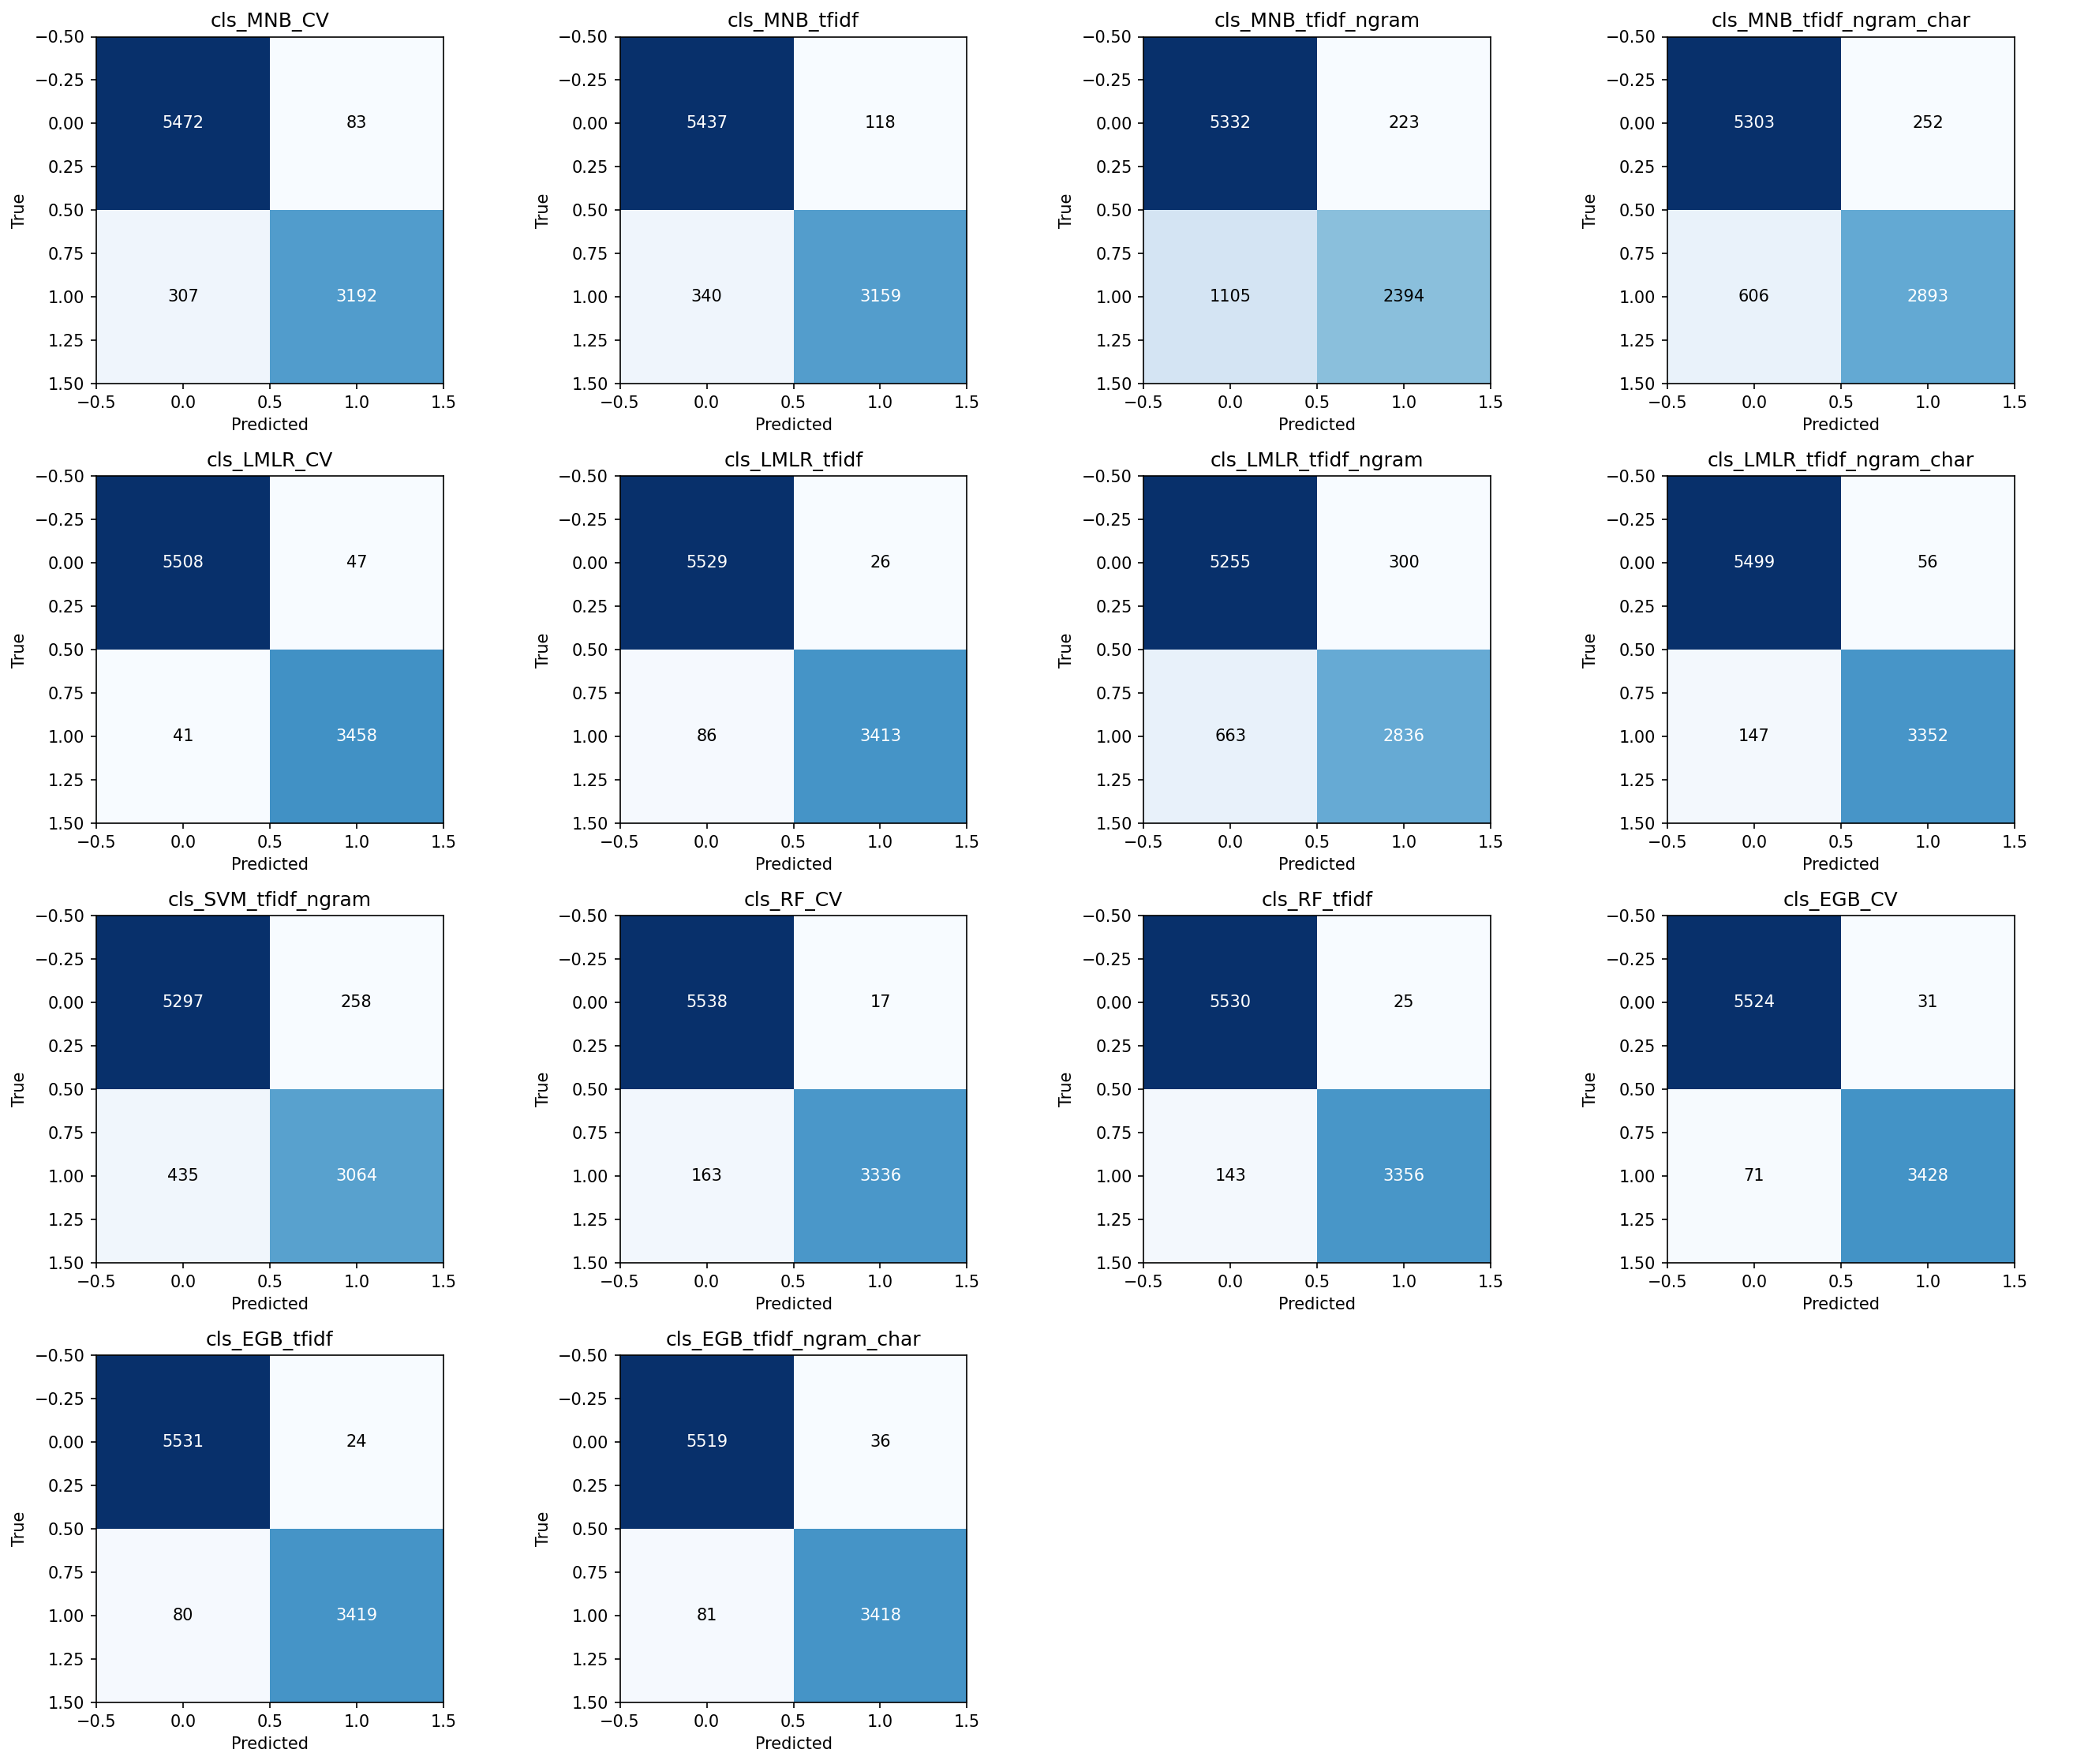

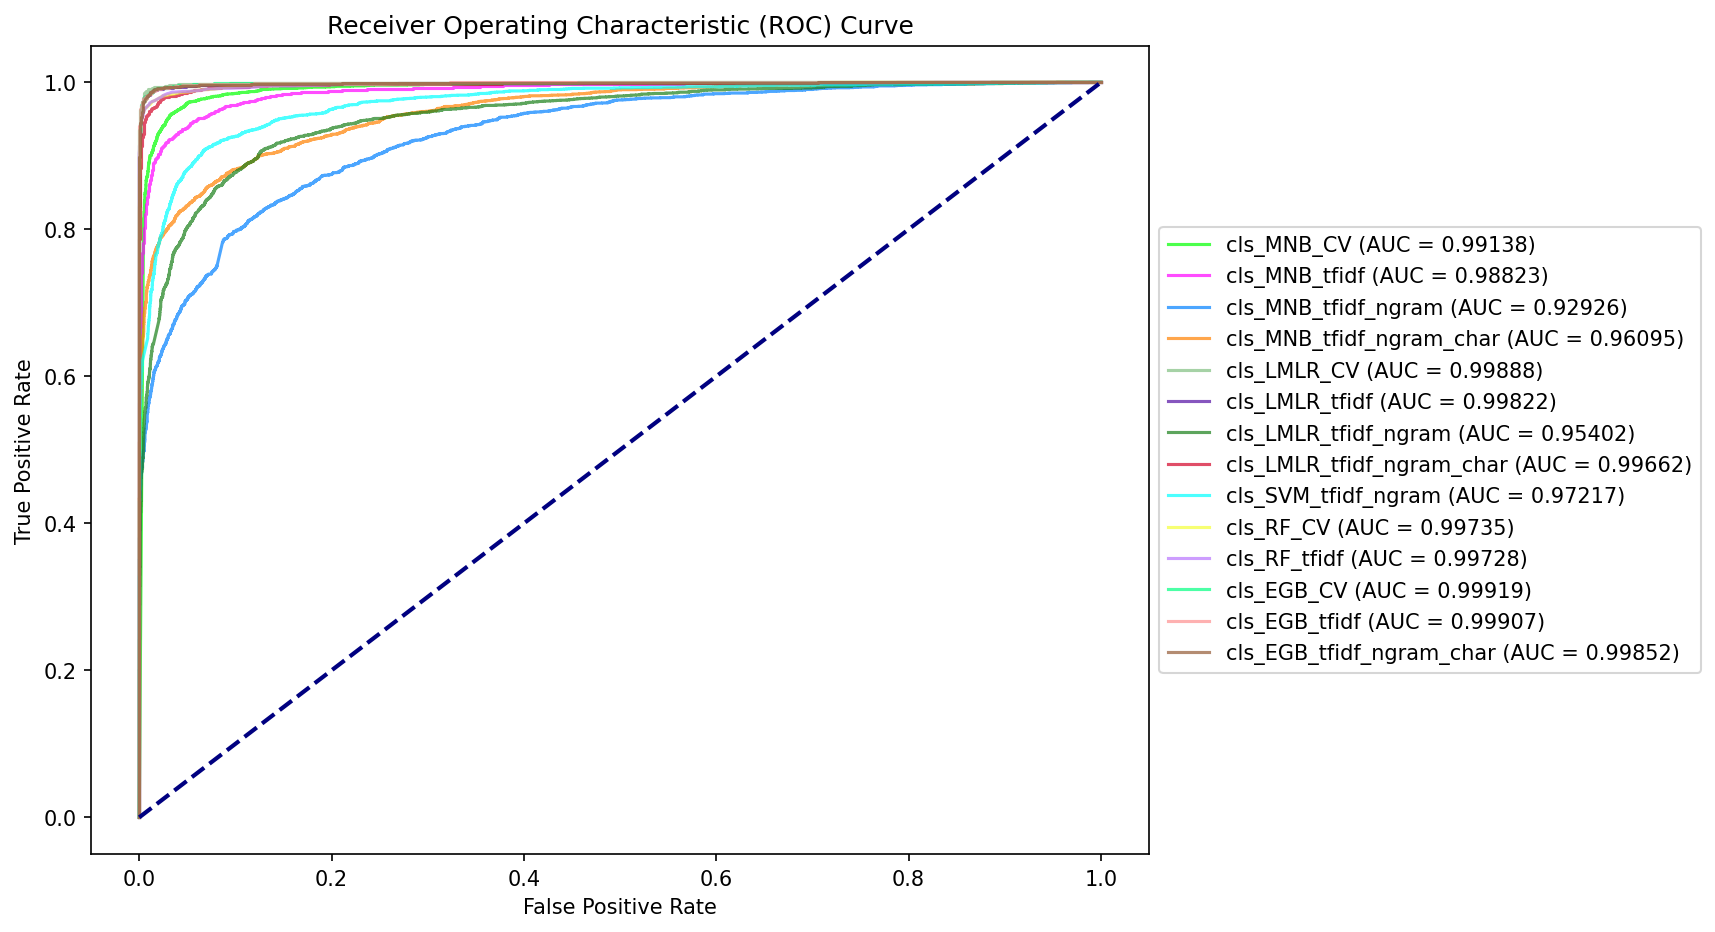

In [28]:
#cls_SVM_tfidf_ngram, cls_RF_CV, cls_RF_tfidf

# models = [cls_MNB_CV, cls_MNB_tfidf, cls_MNB_tfidf_ngram, cls_MNB_tfidf_ngram_char,
#           cls_LMLR_CV, cls_LMLR_tfidf, cls_LMLR_tfidf_ngram, cls_LMLR_tfidf_ngram_char,
#           cls_RF_CV, cls_RF_tfidf,
#           cls_EGB_CV, cls_EGB_tfidf, cls_EGB_tfidf_ngram_char]
model_names = ['cls_MNB_CV', 'cls_MNB_tfidf', 'cls_MNB_tfidf_ngram', 'cls_MNB_tfidf_ngram_char',
               'cls_LMLR_CV', 'cls_LMLR_tfidf', 'cls_LMLR_tfidf_ngram', 'cls_LMLR_tfidf_ngram_char',
               'cls_SVM_tfidf_ngram', 'cls_RF_CV', 'cls_RF_tfidf',
               'cls_EGB_CV', 'cls_EGB_tfidf', 'cls_EGB_tfidf_ngram_char']
x_data = [xtest_count, xtest_tfidf, xtest_tfidf_ngram, xtest_tfidf_ngram_chars,
          xtest_count, xtest_tfidf, xtest_tfidf_ngram, xtest_tfidf_ngram_chars,
          xtest_tfidf_ngram, xtest_count, xtest_tfidf,
          xtest_count.tocsc(), xtest_tfidf.tocsc(), xtest_tfidf_ngram_chars.tocsc()]

y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_models(my_models,
                                                          model_names,
                                                          x_data, test_y,
                                                          is_neural_net = 0,
                                                          num_classes = 2,
                                                          nrows = 4,
                                                          cm_figsize=(18, 15),
                                                          roc_alpha= .7, 
                                                          save_fig = 1,
                                                          label_names = ['clean_text_train_cls_',
                                                                         'clean_text_train_cls_'])

### Shallow Neural Networks
A neural network is a mathematical model that is designed to behave similar to biological neurons and nervous system. These models are used to recognize complex patterns and relationships that exists within a labelled data. A shallow neural network contains mainly three types of layers – input layer, hidden layer, and output layer.

![](./imgs/OH3gI-1.png)

In [29]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(2, activation="softmax")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [30]:
from scipy.sparse import csr_matrix
import numpy as np

# Convert the sparse matrix to a dense NumPy array
dense_xtrain_tfidf = csr_matrix.toarray(xtrain_tfidf)

cls_SNN = create_model_architecture(dense_xtrain_tfidf.shape[1])
t_x, v_x, t_y, v_y = model_selection.train_test_split(dense_xtrain_tfidf, train_y, test_size=0.1, random_state=42)

cls_SNN = train_model(cls_SNN, 
                      feature_vector_train = t_x, 
                      train_label = t_y,
                      feature_vector_valid = v_x,
                      valid_label = v_y,
                      is_neural_net = 1,
                      save_model_path='./cls_SNN_clean_train.h5',
                      epochs = 20)


2024-01-23 03:04:17.041521: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 03:04:17.041728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 03:04:17.041885: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/20


2024-01-23 03:04:24.309771: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1ccc329c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-23 03:04:24.309789: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-23 03:04:24.326589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-23 03:04:24.352720: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1705975464.418756   17787 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1006/1019 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9788

2024-01-23 03:04:26.368164: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72440000 exceeds 10% of free system memory.
2024-01-23 03:04:26.448562: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72440000 exceeds 10% of free system memory.


1019/1019 [==============================] - 4s 2ms/step - loss: 0.0684 - accuracy: 0.9790 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 2/20
   1/1019 [..............................] - ETA: 2s - loss: 0.0033 - accuracy: 1.0000

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - 2s 2ms/step - loss: 0.0137 - accuracy: 0.9961 - val_loss: 0.0240 - val_accuracy: 0.9917
Epoch 3/20
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0307 - val_accuracy: 0.9898
Epoch 4/20
1019/1019 [==============================] - 1s 1ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0294 - val_accuracy: 0.9895
Epoch 5/20
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.0347 - val_accuracy: 0.9901
Epoch 6/20
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0358 - val_accuracy: 0.9892


In [31]:
cls_SNN.predict(csr_matrix.toarray(xtest_tfidf)[:10])

1/1 [==============================] - 0s 44ms/step


array([[1.13542948e-03, 9.98864532e-01],
       [3.23573113e-05, 9.99967694e-01],
       [9.99641180e-01, 3.58834775e-04],
       [1.08002098e-02, 9.89199758e-01],
       [1.01563801e-05, 9.99989867e-01],
       [9.08224463e-01, 9.17755365e-02],
       [1.01438905e-04, 9.99898553e-01],
       [9.99929905e-01, 7.00405435e-05],
       [9.99544203e-01, 4.55794681e-04],
       [2.11917271e-04, 9.99788105e-01]], dtype=float32)

 72/283 [======>.......................] - ETA: 0s

2024-01-23 03:04:36.453787: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 181080000 exceeds 10% of free system memory.


283/283 [==============================] - 0s 763us/step
[[1.1354295e-03 9.9886453e-01]
 [3.2357311e-05 9.9996769e-01]
 [9.9964118e-01 3.5883460e-04]
 ...
 [4.8611453e-04 9.9951386e-01]
 [9.9973172e-01 2.6832573e-04]
 [1.8766872e-04 9.9981230e-01]]


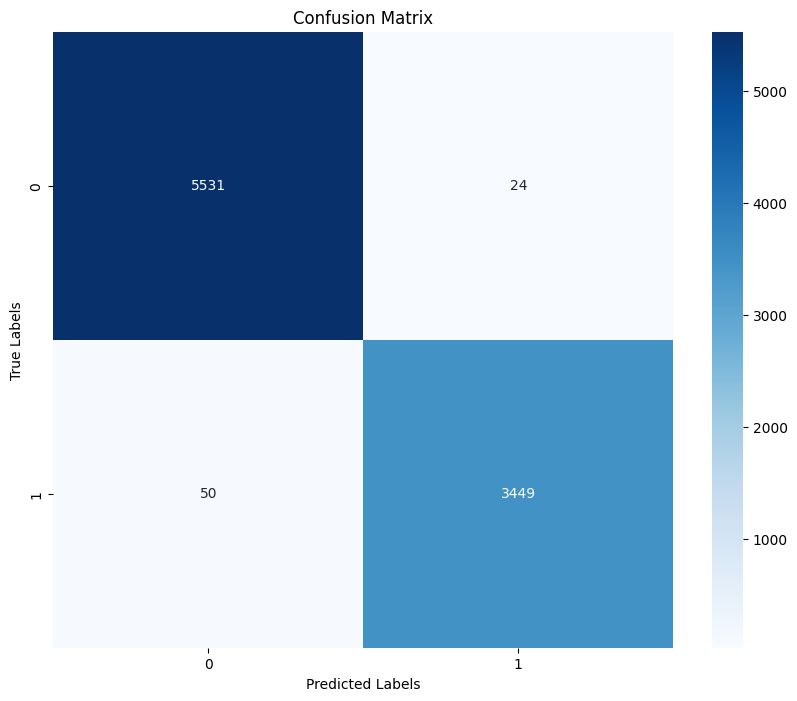

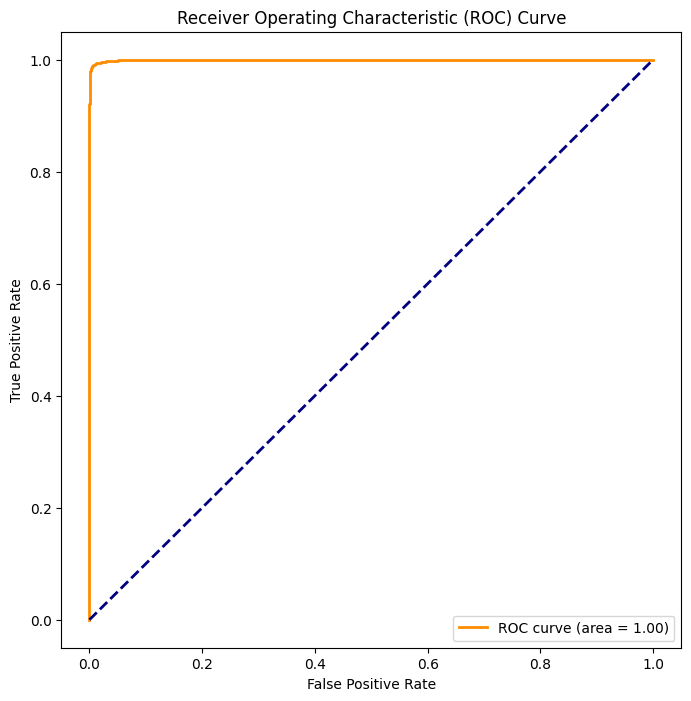

In [32]:
y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_model(cls_SNN,
                                                         csr_matrix.toarray(xtest_tfidf), test_y,
                                                         is_neural_net = 1,
                                                         num_classes = 2)

## Deep Neural Networks
Deep Neural Networks are more complex neural networks in which the hidden layers performs much more complex operations than simple sigmoid or relu activations. Different types of deep learning models can be applied in text classification problems.

![](./imgs/OH3gI.png)
### Convolutional Neural Network
In Convolutional neural networks (CNN), convolutions over the input layer are used to compute the output. This results in local connections, where each region of the input is connected to a neuron in the output. Each layer applies different filters and combines their results.
![](./imgs/cnnimage.png)

In [33]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer = layers.Dense(2, activation="softmax")(output_layer1)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier


In [34]:
t_x, v_x, t_y, v_y = model_selection.train_test_split(train_seq_x, train_y, test_size=0.1, random_state=42)
cls_CNN = create_cnn()
cls_CNN = train_model(cls_CNN, 
                      feature_vector_train = t_x, 
                      train_label = t_y,
                      feature_vector_valid = v_x,
                      valid_label = v_y,
                      is_neural_net = 1,
                      save_model_path='./cls_CNN_clean_train.h5',
                      epochs = 20)

Epoch 1/20
1019/1019 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9221

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - 6s 4ms/step - loss: 0.1965 - accuracy: 0.9221 - val_loss: 0.0980 - val_accuracy: 0.9652
Epoch 2/20
1019/1019 [==============================] - 3s 3ms/step - loss: 0.0854 - accuracy: 0.9701 - val_loss: 0.0966 - val_accuracy: 0.9641
Epoch 3/20
1019/1019 [==============================] - 3s 3ms/step - loss: 0.0595 - accuracy: 0.9800 - val_loss: 0.0688 - val_accuracy: 0.9785
Epoch 4/20
1019/1019 [==============================] - 3s 3ms/step - loss: 0.0449 - accuracy: 0.9848 - val_loss: 0.0614 - val_accuracy: 0.9790
Epoch 5/20
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0362 - accuracy: 0.9872 - val_loss: 0.0664 - val_accuracy: 0.9796
Epoch 6/20
1019/1019 [==============================] - 3s 3ms/step - loss: 0.0277 - accuracy: 0.9908 - val_loss: 0.0545 - val_accuracy: 0.9807
Epoch 7/20
1019/1019 [==============================] - 3s 2ms/step - loss: 0.0270 - accuracy: 0.9910 - val_loss: 0.0587 - val_accuracy: 0.9801
Epo

283/283 [==============================] - 0s 1ms/step
[[5.5245473e-05 9.9994481e-01]
 [5.0309848e-07 9.9999952e-01]
 [9.9999452e-01 5.4841780e-06]
 ...
 [7.6515586e-05 9.9992347e-01]
 [9.9981636e-01 1.8366124e-04]
 [4.1124127e-07 9.9999964e-01]]


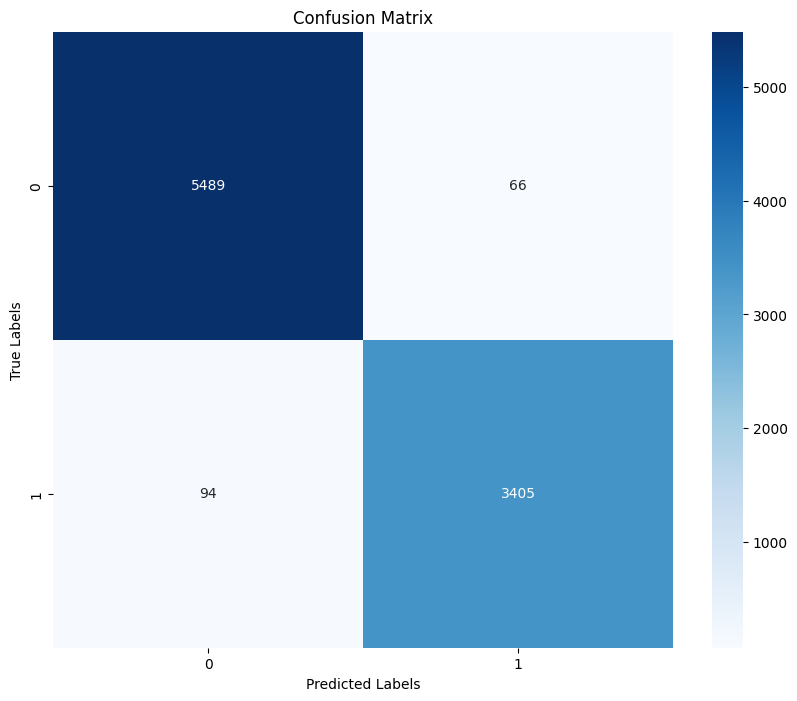

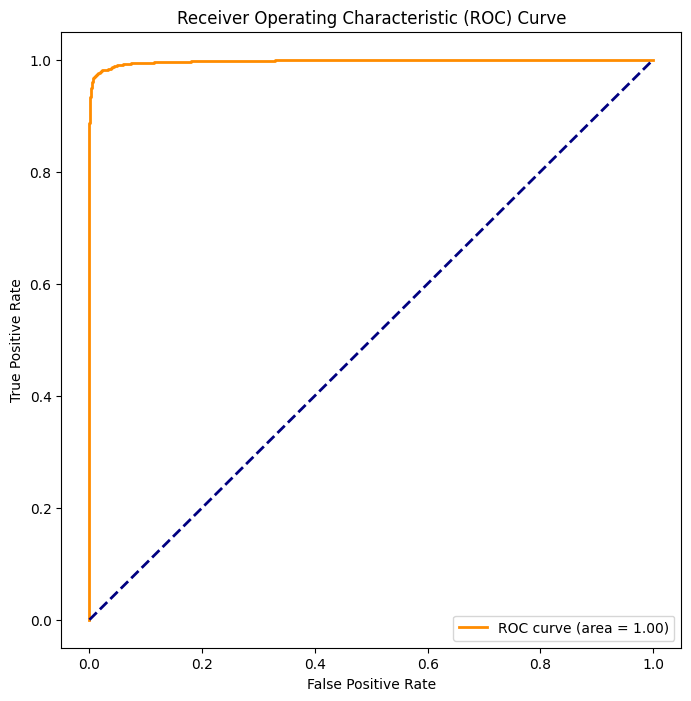

In [35]:
y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_model(cls_CNN,
                                                         test_seq_x, test_y,
                                                         is_neural_net = 1,
                                                         num_classes = 2)

### Recurrent Neural Network – LSTM
Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

![](./imgs/bptt-768x313.png)

In [36]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(2, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [37]:
t_x, v_x, t_y, v_y = model_selection.train_test_split(train_seq_x, train_y, test_size=0.1, random_state=42)
cls_LSTM = create_rnn_lstm()
cls_LSTM = train_model(cls_LSTM, 
                      feature_vector_train = t_x, 
                      train_label = t_y,
                      feature_vector_valid = v_x,
                      valid_label = v_y,
                      is_neural_net = 1,
                      save_model_path='./cls_LSTM_clean_train.h5',
                      epochs = 20)

Epoch 1/20
1018/1019 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8904

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - 9s 6ms/step - loss: 0.2751 - accuracy: 0.8905 - val_loss: 0.2204 - val_accuracy: 0.9205
Epoch 2/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.1842 - accuracy: 0.9327 - val_loss: 0.1229 - val_accuracy: 0.9547
Epoch 3/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.1488 - accuracy: 0.9464 - val_loss: 0.1036 - val_accuracy: 0.9644
Epoch 4/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.1246 - accuracy: 0.9565 - val_loss: 0.1078 - val_accuracy: 0.9636
Epoch 5/20
1019/1019 [==============================] - 6s 6ms/step - loss: 0.1062 - accuracy: 0.9630 - val_loss: 0.0895 - val_accuracy: 0.9696
Epoch 6/20
1019/1019 [==============================] - 6s 6ms/step - loss: 0.0903 - accuracy: 0.9688 - val_loss: 0.0796 - val_accuracy: 0.9760
Epoch 7/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0795 - accuracy: 0.9722 - val_loss: 0.0730 - val_accuracy: 0.9743
Epo

283/283 [==============================] - 1s 2ms/step
[[1.8151375e-05 9.9998188e-01]
 [7.8142264e-08 9.9999988e-01]
 [9.9857855e-01 1.4214924e-03]
 ...
 [1.4693943e-04 9.9985301e-01]
 [9.9872041e-01 1.2795975e-03]
 [2.7971648e-06 9.9999726e-01]]


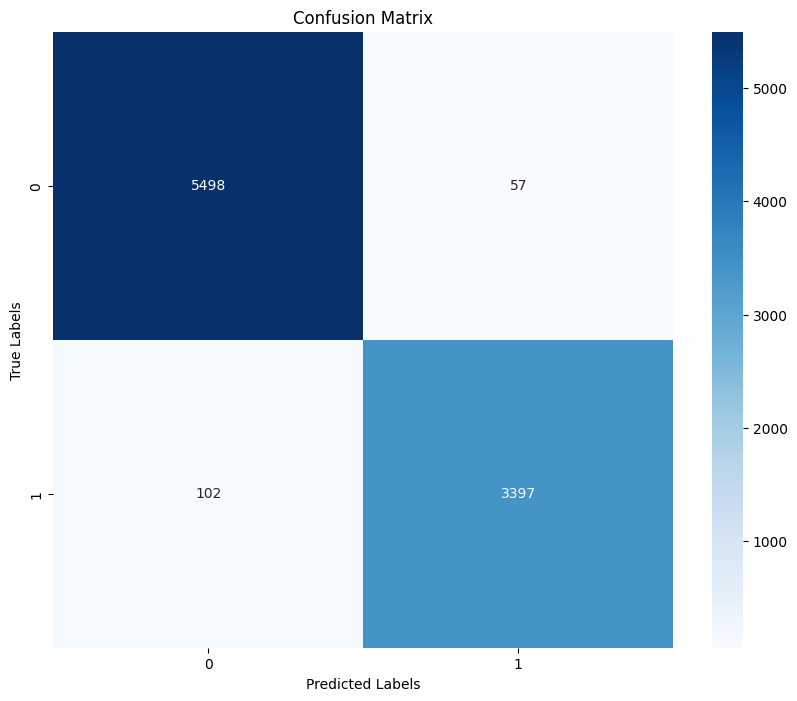

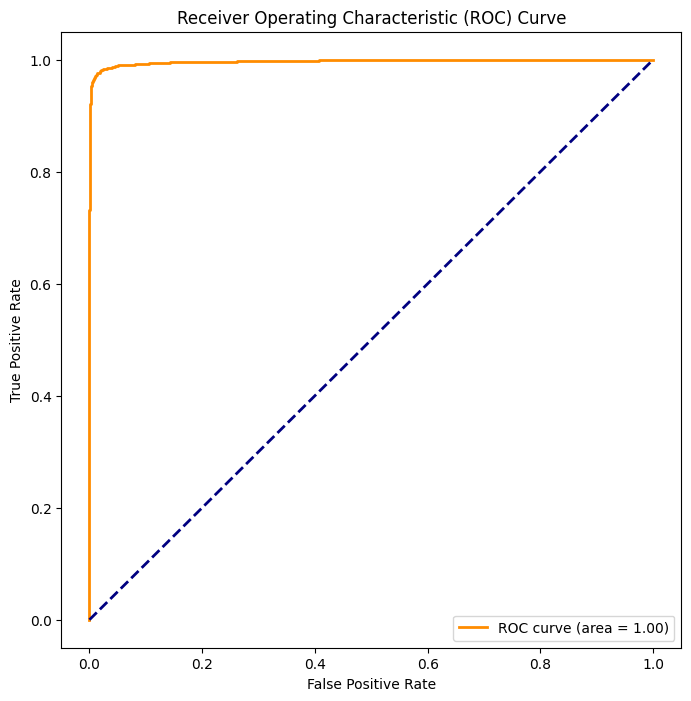

In [38]:
y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_model(cls_LSTM,
                                                         test_seq_x, test_y,
                                                         is_neural_net = 1,
                                                         num_classes = 2)

### Recurrent Neural Network – GRU
Gated Recurrent Units are another form of recurrent neural networks. Lets add a layer of GRU instead of LSTM in our network.

In [39]:
def create_rnn_gru():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(2, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [40]:
t_x, v_x, t_y, v_y = model_selection.train_test_split(train_seq_x, train_y, test_size=0.1, random_state=42)
cls_GRU = create_rnn_gru()
cls_GRU = train_model(cls_GRU, 
                      feature_vector_train = t_x, 
                      train_label = t_y,
                      feature_vector_valid = v_x,
                      valid_label = v_y,
                      is_neural_net = 1,
                      save_model_path='./cls_GRU_clean_train.h5',
                      epochs = 20)

Epoch 1/20
1011/1019 [============================>.] - ETA: 0s - loss: 0.2737 - accuracy: 0.8872

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - 7s 6ms/step - loss: 0.2731 - accuracy: 0.8874 - val_loss: 0.1777 - val_accuracy: 0.9337
Epoch 2/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.1614 - accuracy: 0.9407 - val_loss: 0.1118 - val_accuracy: 0.9564
Epoch 3/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.1208 - accuracy: 0.9563 - val_loss: 0.0946 - val_accuracy: 0.9671
Epoch 4/20
1019/1019 [==============================] - 6s 6ms/step - loss: 0.0950 - accuracy: 0.9674 - val_loss: 0.0938 - val_accuracy: 0.9666
Epoch 5/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0791 - accuracy: 0.9715 - val_loss: 0.0734 - val_accuracy: 0.9754
Epoch 6/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0662 - accuracy: 0.9764 - val_loss: 0.0710 - val_accuracy: 0.9776
Epoch 7/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0537 - accuracy: 0.9815 - val_loss: 0.0649 - val_accuracy: 0.9793
Epo

283/283 [==============================] - 1s 2ms/step
[[6.08450000e-06 9.99993920e-01]
 [1.00596005e-13 1.00000000e+00]
 [9.99990821e-01 9.19576905e-06]
 ...
 [1.78003870e-02 9.82199550e-01]
 [9.99972105e-01 2.78916868e-05]
 [1.23828968e-05 9.99987602e-01]]


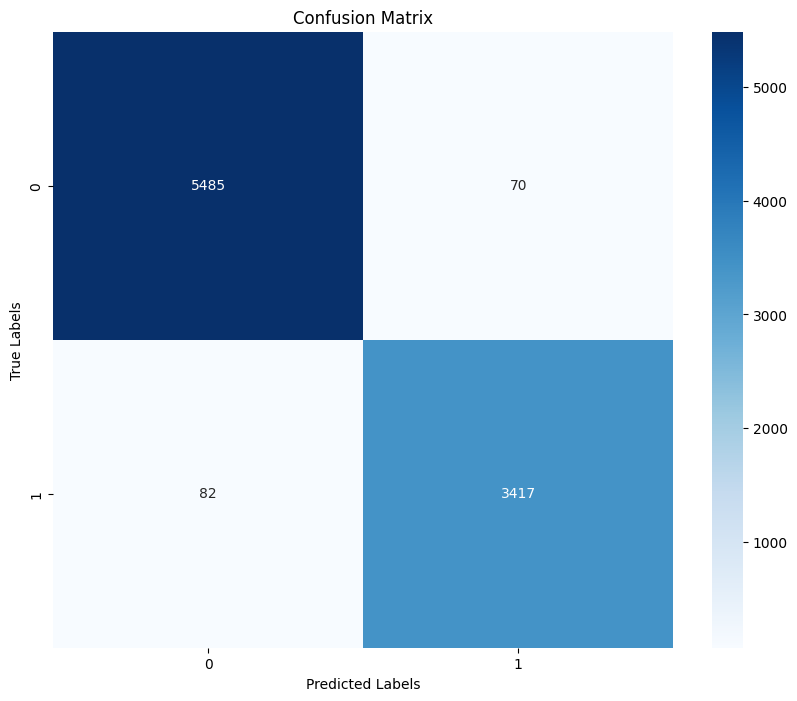

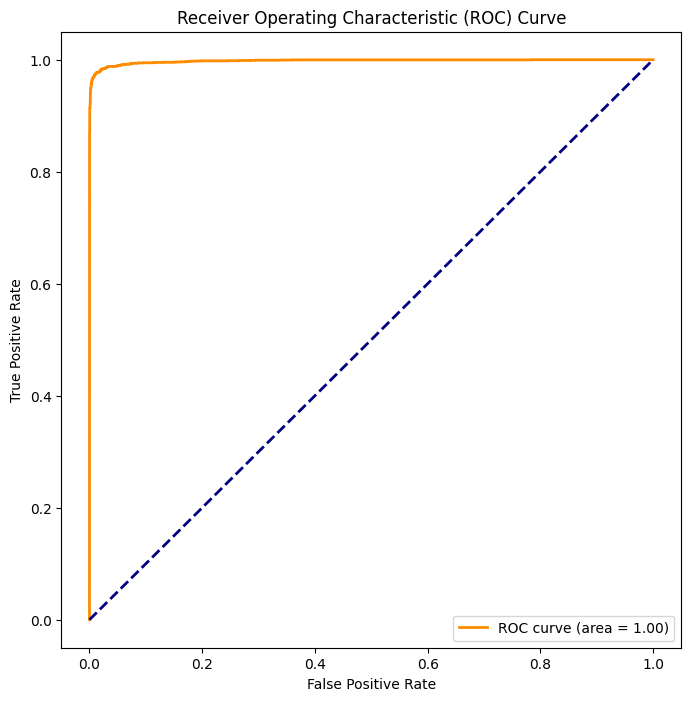

In [41]:
y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_model(cls_GRU,
                                                         test_seq_x, test_y,
                                                         is_neural_net = 1,
                                                         num_classes = 2)

### Bidirectional RNN
RNN layers can be wrapped in Bidirectional layers as well. Lets wrap our GRU layer in bidirectional layer.

In [42]:
def create_bidirectional_rnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(2, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [43]:
t_x, v_x, t_y, v_y = model_selection.train_test_split(train_seq_x, train_y, test_size=0.1, random_state=42)
cls_BRNN = create_rnn_gru()
cls_BRNN = train_model(cls_BRNN, 
                      feature_vector_train = t_x, 
                      train_label = t_y,
                      feature_vector_valid = v_x,
                      valid_label = v_y,
                      is_neural_net = 1,
                      save_model_path='./cls_BRNN_clean_train.h5',
                      epochs = 20)

Epoch 1/20
1017/1019 [============================>.] - ETA: 0s - loss: 0.2782 - accuracy: 0.8859

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - 7s 6ms/step - loss: 0.2780 - accuracy: 0.8860 - val_loss: 0.1654 - val_accuracy: 0.9404
Epoch 2/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.1600 - accuracy: 0.9410 - val_loss: 0.1195 - val_accuracy: 0.9558
Epoch 3/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.1188 - accuracy: 0.9582 - val_loss: 0.0922 - val_accuracy: 0.9655
Epoch 4/20
1019/1019 [==============================] - 4s 4ms/step - loss: 0.0956 - accuracy: 0.9661 - val_loss: 0.1069 - val_accuracy: 0.9660
Epoch 5/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0839 - accuracy: 0.9707 - val_loss: 0.0770 - val_accuracy: 0.9754
Epoch 6/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0699 - accuracy: 0.9758 - val_loss: 0.0712 - val_accuracy: 0.9768
Epoch 7/20
1019/1019 [==============================] - 5s 5ms/step - loss: 0.0585 - accuracy: 0.9804 - val_loss: 0.0667 - val_accuracy: 0.9779
Epo

283/283 [==============================] - 1s 2ms/step
[[3.8132316e-04 9.9961865e-01]
 [2.0713701e-06 9.9999797e-01]
 [9.9953306e-01 4.6694334e-04]
 ...
 [6.7914024e-02 9.3208599e-01]
 [9.9911851e-01 8.8150997e-04]
 [1.2114744e-04 9.9987888e-01]]


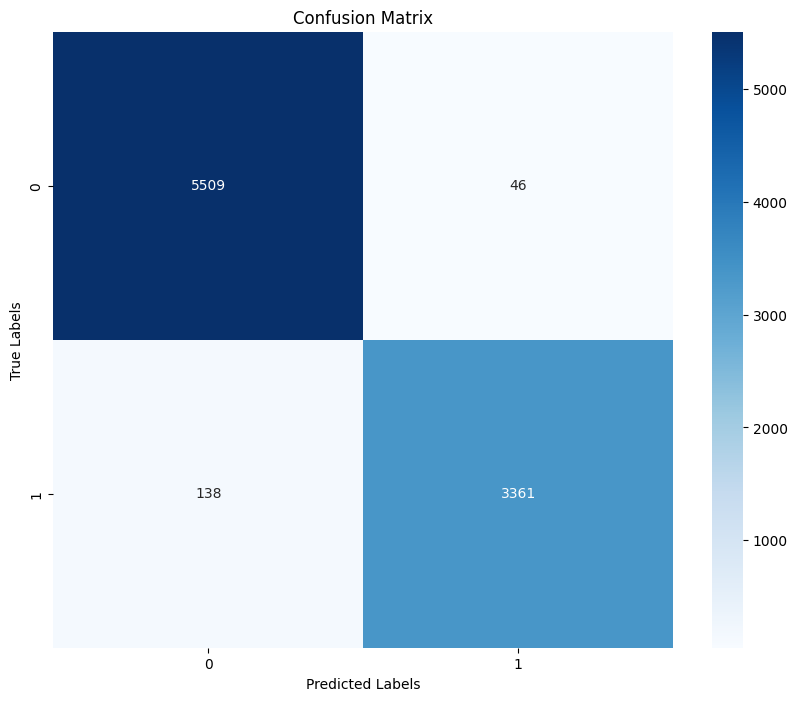

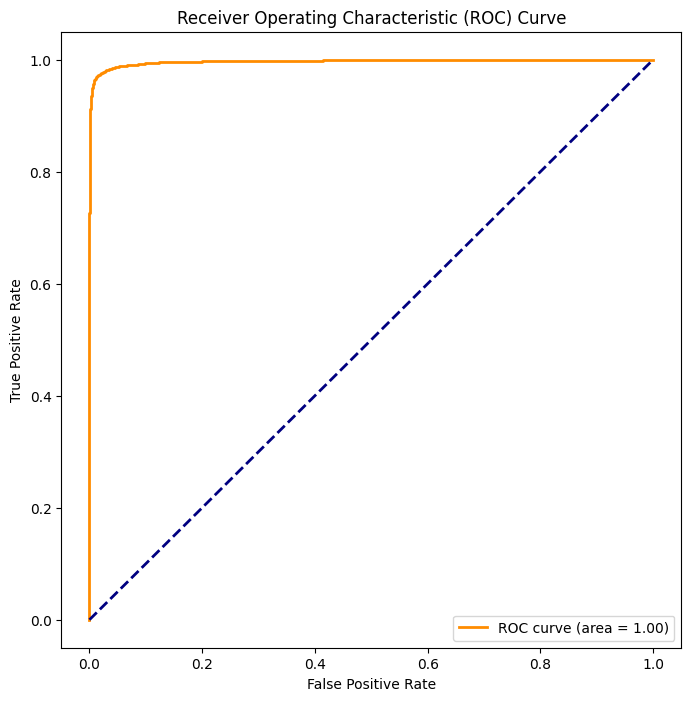

In [44]:
y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_model(cls_BRNN,
                                                         test_seq_x, test_y,
                                                         is_neural_net = 1,
                                                         num_classes = 2)

### Recurrent Convolutional Neural Network
Once the essential architectures have been tried out, one can try different variants of these layers such as recurrent convolutional neural network. Another variants can be:

1. Hierarichial Attention Networks
2. Sequence to Sequence Models with Attention
3. Bidirectional Recurrent Convolutional Neural Networks
4. CNNs and RNNs with more number of layers

In [45]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(2, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [46]:
t_x, v_x, t_y, v_y = model_selection.train_test_split(train_seq_x, train_y, test_size=0.1, random_state=42)
cls_RCNN = create_rcnn()
cls_RCNN = train_model(cls_RCNN, 
                      feature_vector_train = t_x, 
                      train_label = t_y,
                      feature_vector_valid = v_x,
                      valid_label = v_y,
                      is_neural_net = 1,
                      save_model_path='./cls_RCNN_clean_train.h5',
                      epochs = 20)

Epoch 1/20
1002/1019 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9195

/home/syntax_error/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - 4s 3ms/step - loss: 0.2018 - accuracy: 0.9201 - val_loss: 0.0848 - val_accuracy: 0.9702
Epoch 2/20
1019/1019 [==============================] - 3s 3ms/step - loss: 0.0850 - accuracy: 0.9709 - val_loss: 0.0780 - val_accuracy: 0.9707
Epoch 3/20
1019/1019 [==============================] - 3s 3ms/step - loss: 0.0592 - accuracy: 0.9799 - val_loss: 0.0535 - val_accuracy: 0.9818
Epoch 4/20
1019/1019 [==============================] - 3s 3ms/step - loss: 0.0447 - accuracy: 0.9843 - val_loss: 0.0562 - val_accuracy: 0.9790
Epoch 5/20
1019/1019 [==============================] - 2s 2ms/step - loss: 0.0349 - accuracy: 0.9875 - val_loss: 0.0539 - val_accuracy: 0.9809
Epoch 6/20
1019/1019 [==============================] - 3s 2ms/step - loss: 0.0299 - accuracy: 0.9895 - val_loss: 0.0548 - val_accuracy: 0.9812
Epoch 7/20
1019/1019 [==============================] - 3s 2ms/step - loss: 0.0234 - accuracy: 0.9914 - val_loss: 0.0607 - val_accuracy: 0.9818
Epo

283/283 [==============================] - 0s 695us/step
[[1.0508142e-03 9.9894923e-01]
 [2.1483063e-05 9.9997854e-01]
 [9.9987459e-01 1.2535497e-04]
 ...
 [1.4082514e-03 9.9859172e-01]
 [9.9980634e-01 1.9371585e-04]
 [3.3032146e-04 9.9966967e-01]]


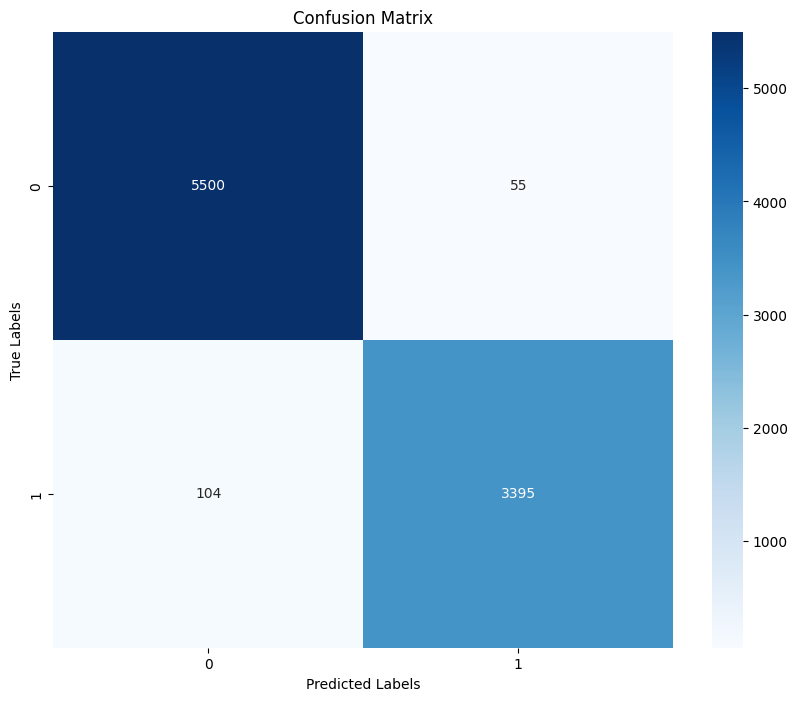

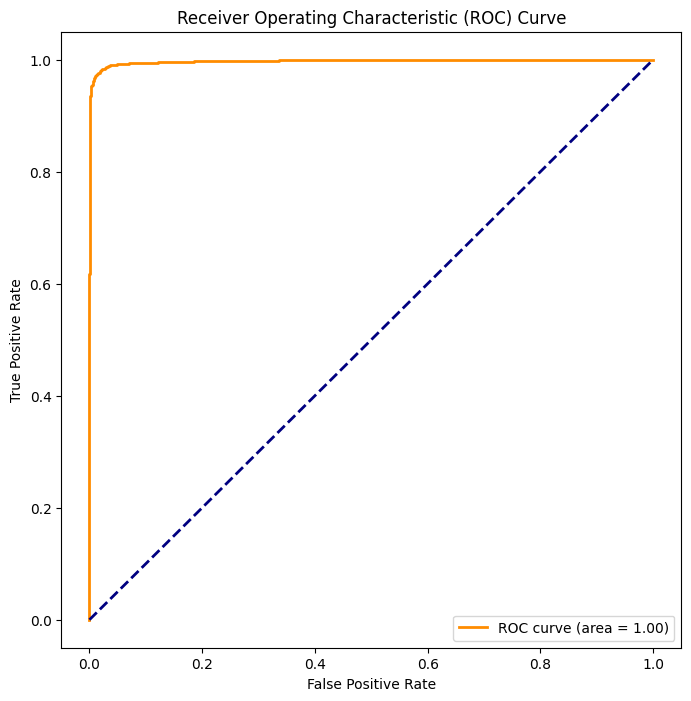

In [47]:
y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_model(cls_RCNN,
                                                         test_seq_x, test_y,
                                                         is_neural_net = 1,
                                                         num_classes = 2)

In [48]:
def load_CNN_model(model_path):
    """
    Load a Keras model from a specified path.

    Parameters:
    - model_path (str): Full path to the saved model file (.h5).

    Returns:
    - model: Loaded Keras model.
    """
    try:
        model = models.load_model(model_path)
        print(f'Model loaded successfully from {model_path}')
        return model
    except Exception as e:
        print(f'Error loading the model from {model_path}: {e}')
        return None


In [49]:
load2 = 1

if load2:
    # cls_MNB_CV, cls_MNB_tfidf, cls_MNB_tfidf_ngram, cls_MNB_tfidf_ngram_char = None, None, None, None
    # cls_LMLR_CV, cls_LMLR_tfidf, cls_LMLR_tfidf_ngram, cls_LMLR_tfidf_ngram_char = None, None, None, None
    # cls_RF_CV, cls_RF_tfidf = None, None
    # cls_EGB_CV, cls_EGB_tfidf, cls_EGB_tfidf_ngram_char = None, None, None
    my_CNN_models = []

    CNN_model_paths = ['./cls_SNN_clean_train.h5', './cls_CNN_clean_train.h5', './cls_LSTM_clean_train.h5', './cls_GRU_clean_train.h5',
                './cls_BRNN_clean_train.h5', './cls_RCNN_clean_train.h5']

    for path in CNN_model_paths:
        my_CNN_models.append(load_CNN_model(path))

Model loaded successfully from ./cls_SNN_clean_train.h5
Model loaded successfully from ./cls_CNN_clean_train.h5
Model loaded successfully from ./cls_LSTM_clean_train.h5
Model loaded successfully from ./cls_GRU_clean_train.h5
Model loaded successfully from ./cls_BRNN_clean_train.h5
Model loaded successfully from ./cls_RCNN_clean_train.h5


In [50]:
my_CNN_models

283/283 [==============================] - 0s 720us/step


/tmp/ipykernel_17186/2292697846.py:199: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_17186/2292697846.py:200: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  roc_fig.show()


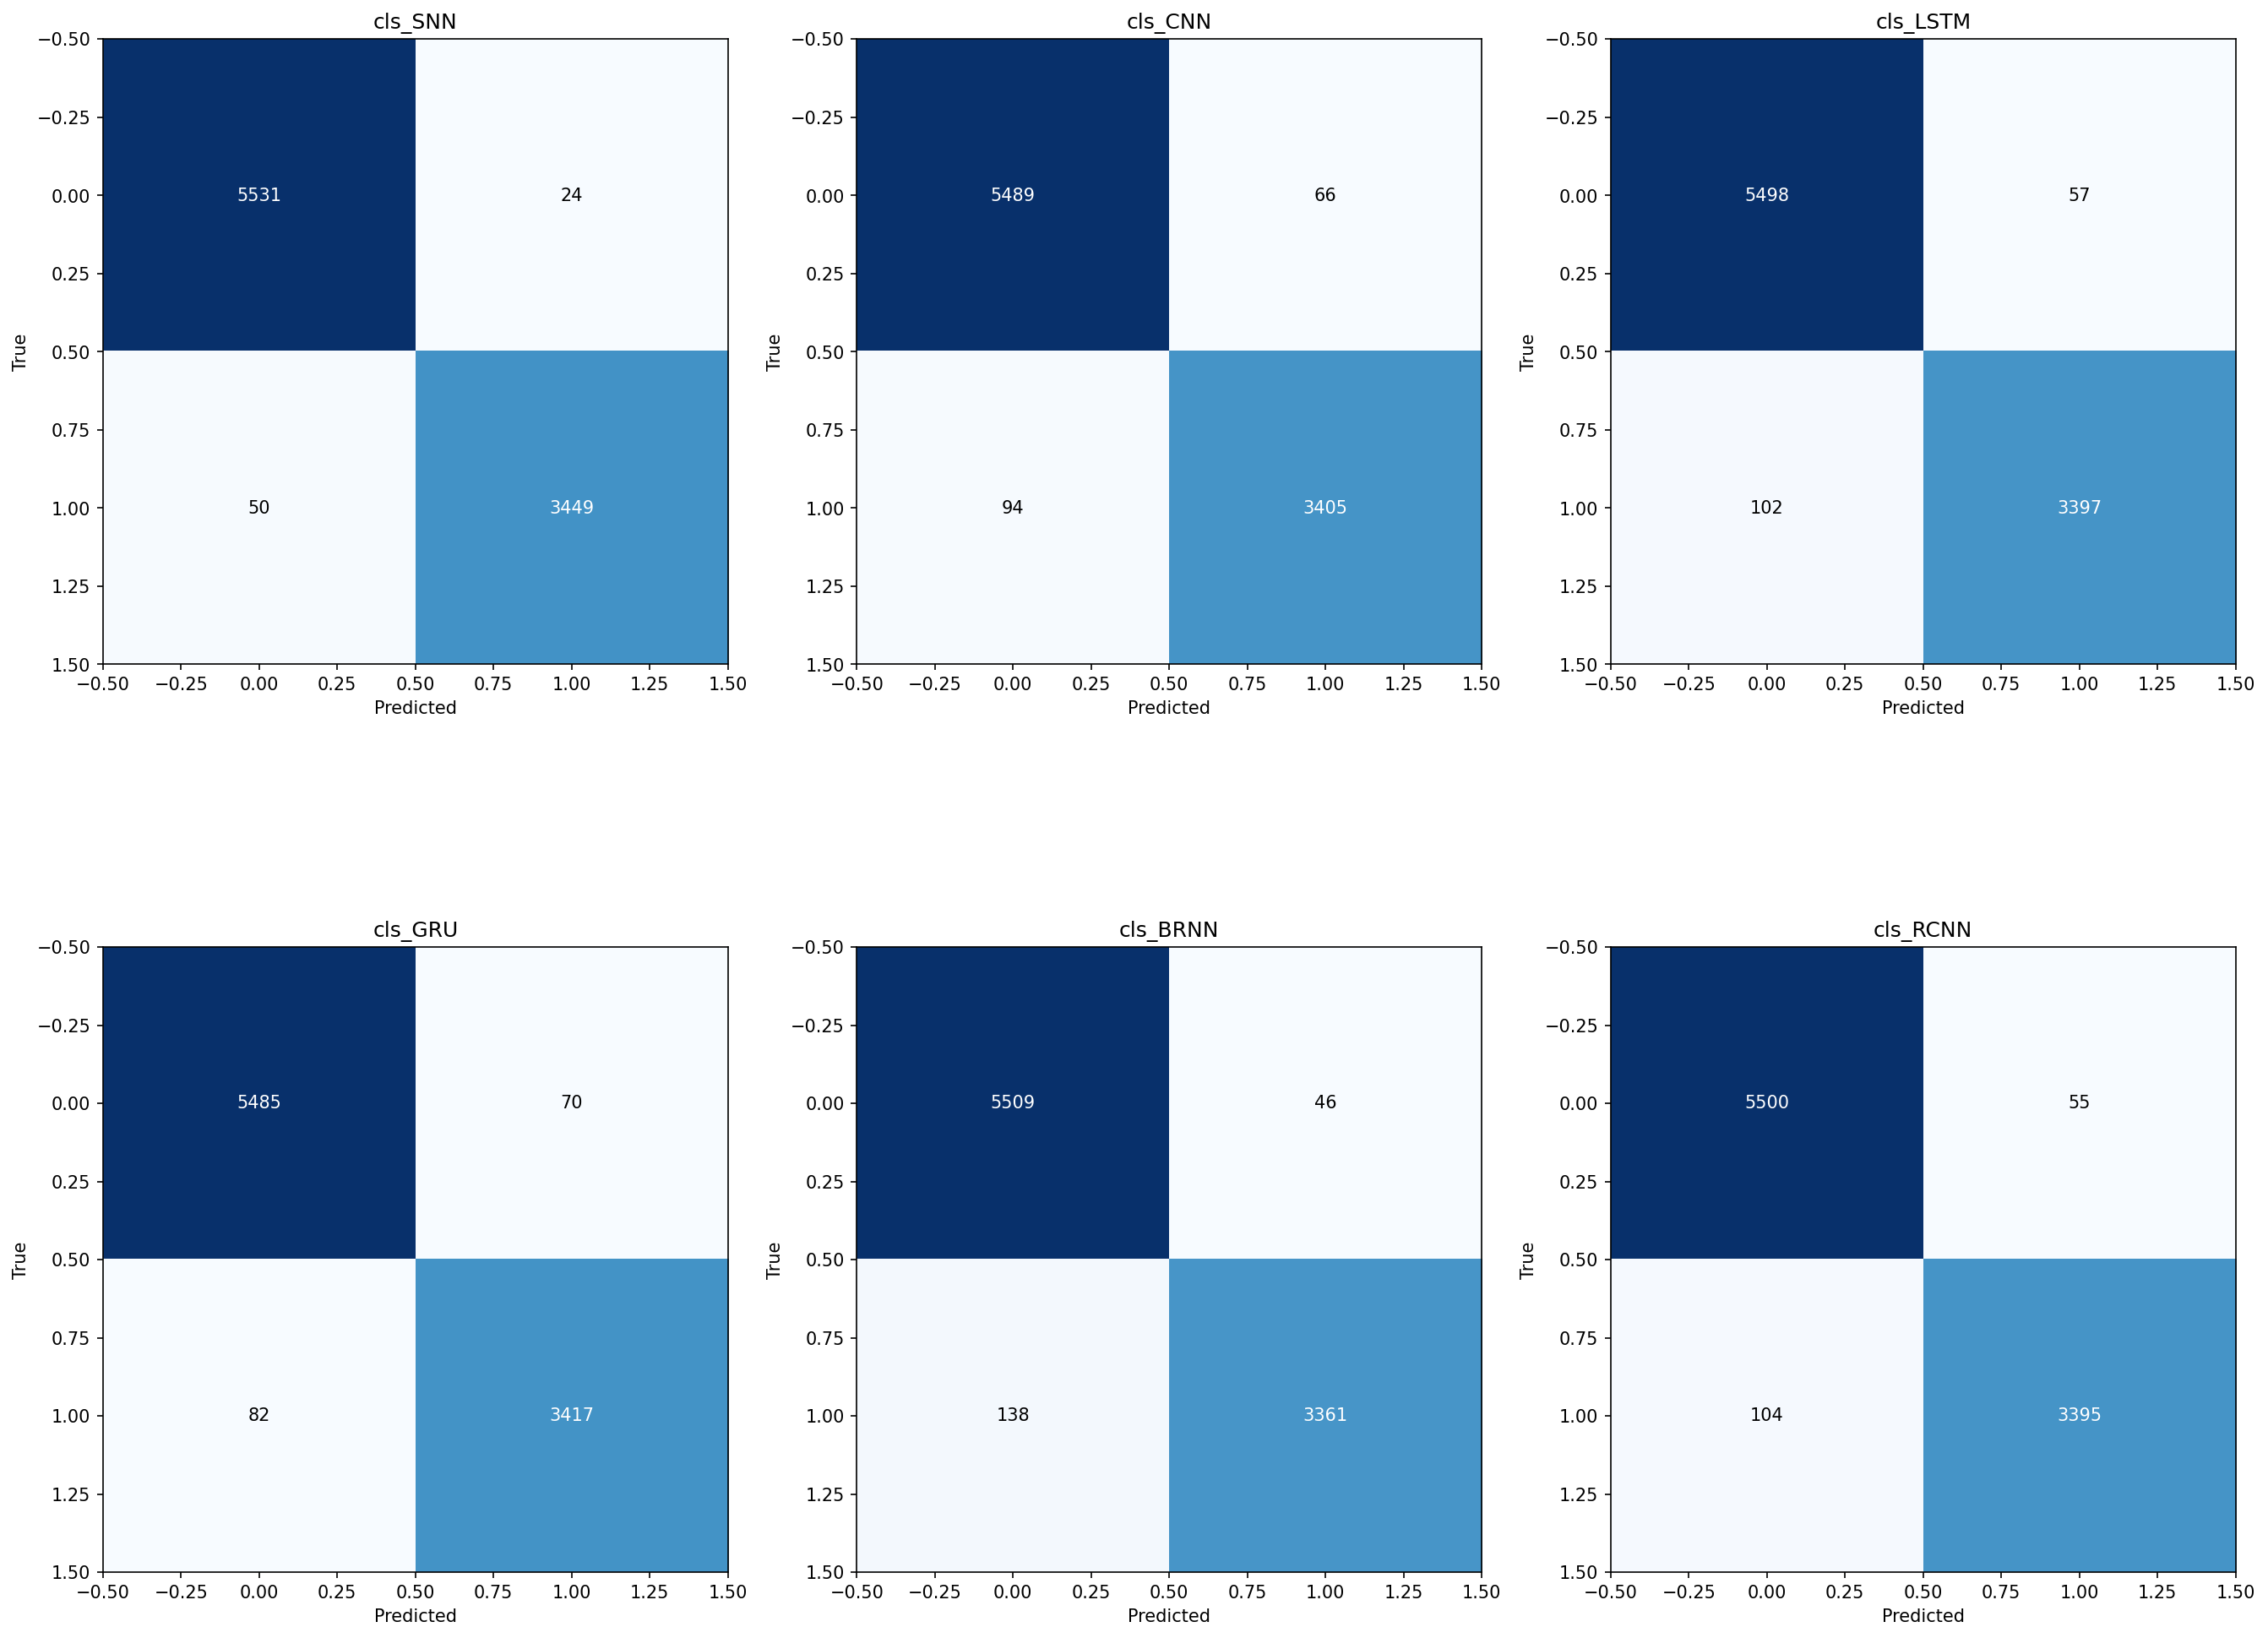

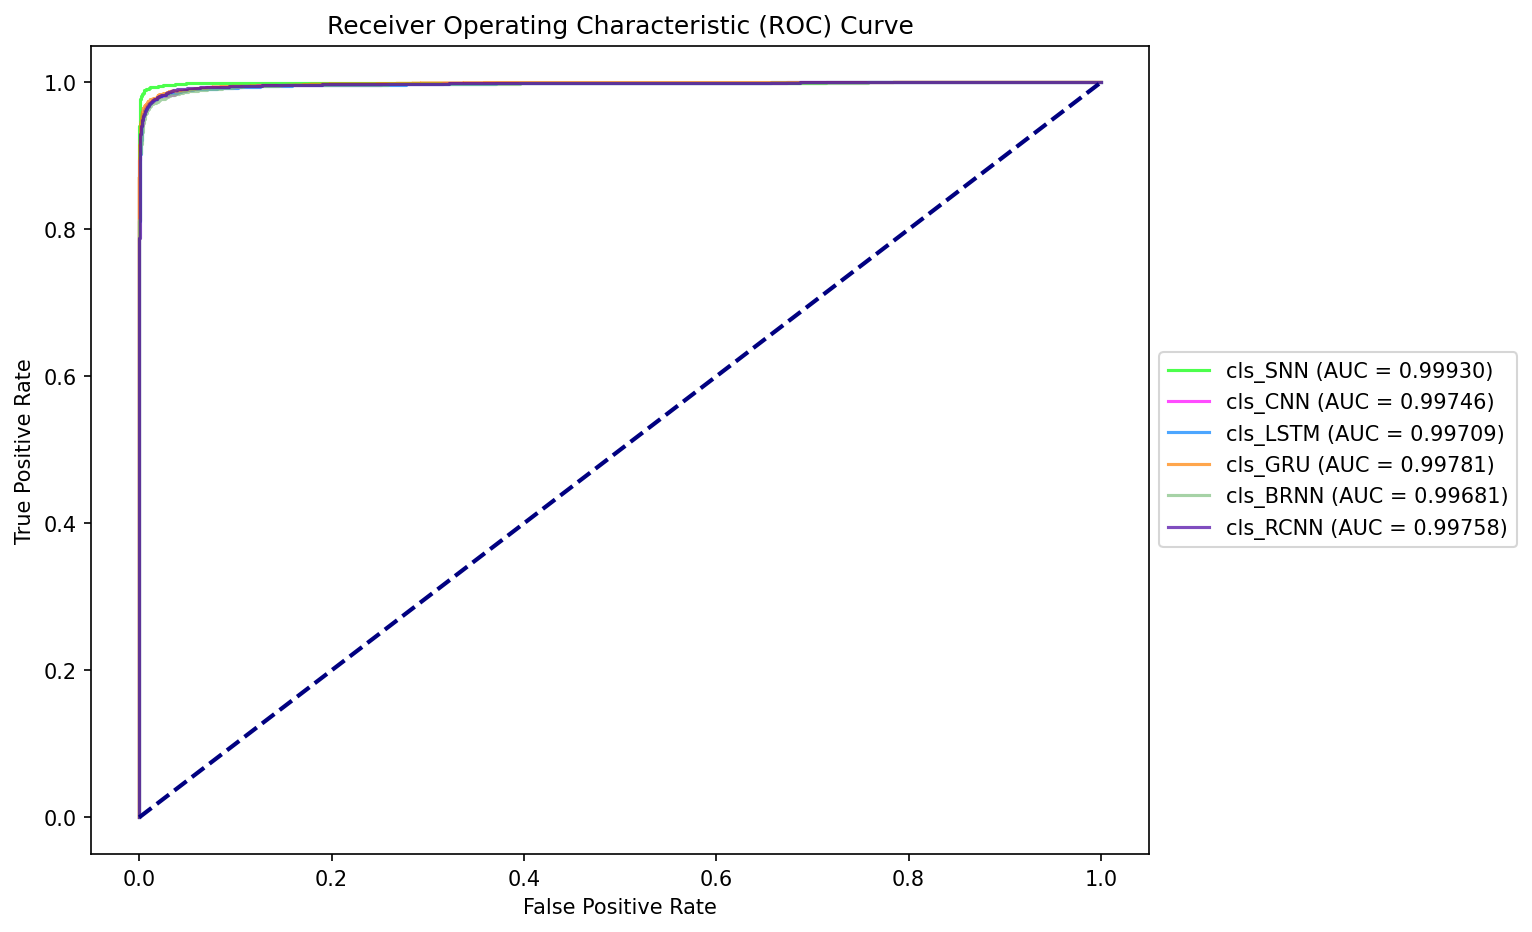

In [52]:
CNN_model_names = ['cls_SNN', 'cls_CNN', 'cls_LSTM', 'cls_GRU',
                'cls_BRNN', 'cls_RCNN']
x_data = [csr_matrix.toarray(xtest_tfidf), test_seq_x, test_seq_x, test_seq_x,
          test_seq_x, test_seq_x]

y_preds, y_probs, cm, fpr, tpr, roc_auc = evaluate_models(my_CNN_models,
                                                          CNN_model_names,
                                                          x_data, test_y,
                                                          is_neural_net = 1,
                                                          num_classes = 2,
                                                          nrows = 2,
                                                          cm_figsize=(18, 15),
                                                          roc_alpha= .7,
                                                          save_fig = 1,
                                                          label_names = ['clean_text_train_NN_',
                                                                         'clean_text_train_NN_'])

In [25]:

shortuuid.uuid()

'oGEgXpPTGKqyeVP3ZeUCDF'